In [1]:
%matplotlib inline


from google.colab import drive
drive.mount('/content/drive/')

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from model import *
from post_processing import *
from augmentation import *
import os,sys
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Using TensorFlow backend.


In [0]:
#Set variables
n_imgs = 100
split_rate = 0.9
img_shape =16
step = 16
pad = 10
batch = 1000
epoch = 10
rotations = 2
class_weight = {0: 20,1: 1}
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

Loading 100 images
Loading 100 ground truth images


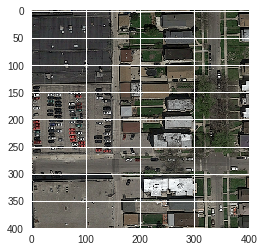

In [3]:
# Loaded a set of images
drivedir = "drive/My Drive/"
root_dir = "training/"
directory = drivedir+root_dir

imgs, gt_imgs = load_train_images(n_imgs,directory)

train_imgs, test_imgs, train_gt, test_gt = split_data(imgs,gt_imgs,split_rate)
plt.imshow(train_imgs[0], cmap='Greys_r')

In [0]:

x_train, y_train = make_patches(img_shape, train_imgs, train_gt,step,pad)
x_test, y_test = make_patches(img_shape, test_imgs, test_gt,step,pad)
  
  
# Compute features for each image patch
y_test = np.asarray([value_to_class(np.mean(y_test[i]),foreground_threshold) 
                     for i in range(len(y_test))])
y_train = np.asarray([value_to_class(np.mean(y_train[i]),foreground_threshold) 
                     for i in range(len(y_train))])
x_train, y_train = add_rotated_imgs(x_train, y_train,rotations+1)

In [5]:
model = make_model(img_shape,pad)



/content/model.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(36, 36, 3..., padding="same")`
  input_shape=input_shape))
/content/model.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  border_mode="same"
/content/model.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  border_mode="same"


In [0]:
print(x_train.shape)
model.fit(x_train,y_train,batch_size=batch, epochs = epoch,validation_data = (x_test,y_test), shuffle=True)

(168750, 36, 36, 3)
Train on 168750 samples, validate on 6250 samples
Epoch 1/10
168750/168750 [==============================] - 98s 582us/step - loss: 0.5088 - acc: 0.7432 - val_loss: 0.4701 - val_acc: 0.7779
Epoch 2/10
 42000/168750 [======>.......................] - ETA: 1:04 - loss: 0.4501 - acc: 0.7683

In [0]:
x_test, y_test = make_patches(img_shape, test_imgs, test_gt,step,pad)
  
  
# Compute features for each image patch
y_test = np.asarray([value_to_class(np.mean(y_test[i]),foreground_threshold) 
                     for i in range(len(y_test))])

In [0]:
# Predict on the training set
def get_best_prediction(x_test,y_test, model, remove,n_images):
    Z = model.predict(x_test)
    max_f1 = best_tresh = 0
    best_rec =best_prec= 0 
    best_Z = Z
    best_min_clique = 0
    for tresh in np.linspace(0.2,0.7,25): 
        Z_copy = Z.copy()
        for i in range (len(Z_copy)):
            if(Z_copy[i]<tresh):
                Z_copy[i] =0
            else:
                Z_copy[i]=1
        #print(sum(Z_copy),len(Z_copy))
         # if(remove):
        for min_clique in np.linspace(0,20, 21):
          Z_copy = remove_singles(Z_copy,n_images,25)
          Z_copy = remove_small_cliques(Z_copy,n_images,25,min_clique)

            
          #print(sum(Z_copy),len(Z_copy))
          F1, Precision, Recall = scores(Z_copy, y_test)
          if(F1 > max_f1):
              best_min_clique = min_clique
              best_Z = Z_copy.copy()
              max_f1 = F1
              best_tresh = tresh
              best_rec = Recall
              best_prec = Precision
              print('Precision = ' + str(best_prec))
              print('Recall = ' + str(best_rec))
              print('F1 = ' + str(max_f1))
              print("Best_tres = "+str(best_tresh))
              print("Best min_clique ="+str(best_min_clique),"\n")
    best_Z = np.reshape(best_Z, y_test.shape) # C-like index ordering
    print('Precision = ' + str(best_prec))
    print('Recall = ' + str(best_rec))
    print('F1 = ' + str(max_f1))
    print("Best_tres = "+str(best_tresh))
    print("Best min_clique ="+str(best_min_clique))
    return best_Z
pred = get_best_prediction(x_test,y_test,model, True,10)#len(test_imgs))

In [0]:
# Run prediction on the img_idx-th image
def predict_images(images, patch_size,treshold):
  
  print(type(imgs))
  Xi, correct_labeling_testing =make_patches(patch_size,imgs[images],gt_imgs[images],step_size,padding)

  correct_labeling_testimg = np.asarray([value_to_class(np.mean(correct_labeling_testimg[i]),foreground_treshold)
                                         for i in range(len(correct_labeling_testimg))])
  Zi = model.predict(Xi)
  for i in range (len(Zi)):
      if(Zi[i]<treshold):
          Zi[i] =0
      else:
          Zi[i]=1
  Zi = np.reshape(Zi, ((625*len(images)),))
  return Zi, correct_labeling_testimg

In [0]:
# Display prediction as an image
def show_prediction(Zi, correct_labeling_testimg, test_imgs):
    patch_size = 16
    i = 0
    patches_per_image = len(Zi)/len(test_imgs)
    for index in range(len(test_imgs)):
        pred = Zi[int(i*patches_per_image):int((i+1)*patches_per_image)]
        correct = correct_labeling_testimg[int(i*patches_per_image):int((i+1)*patches_per_image)]
        pred = take_isolated(pred, 25)
        pred = find_clique(pred,25,10)         
        w = gt_imgs[index].shape[0]
        h = gt_imgs[index].shape[1]
        predicted_im = label_to_img(w, h, patch_size, patch_size, pred)
        correct_im = label_to_img(w, h, patch_size, patch_size, correct)
        cimg = concatenate_images(test_imgs[index], predicted_im)
        cimg = concatenate_images(cimg, correct_im)
        fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
        plt.imshow(cimg, cmap='Greys_r')
        i+=1
    return

pred = np.reshape(pred, ((625*len(test_imgs)),))
show_prediction(pred, y_test, test_imgs)


In [0]:
new_img = make_img_overlay(imgs[0], predicted_im)

plt.imshow(new_img)